In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### Loading FMNIST dataset into train-val-test set

In [2]:
import torchvision.transforms as transforms 
import torchvision.datasets as datasets

<br/>

<img src='../images/fashion-mnist-sprite.png' width=500px/>

<br/>

**train-test-transform**

In [3]:
# Define a transform to normalize the data
train_transform = transforms.Compose([transforms.RandomResizedCrop((28, 28)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [5]:
train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=train_transform)

# val-dataset refers to the same dataset as train-dataset, however, while validating the model's performance
# we do not use any random-transformation
val_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=test_transform)

test_dataset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=test_transform)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...


/users/gpu/soumyab/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1597302511511/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


**Separating train-set into train & validation set**
- Let's set validation set size as 20%, therefore, we will be using 80% of training set for training 
    the neural network
- Validating a model while training w.r.t a validation-set can help us from overfitting
- Validation-set works as an alternative to the actual test-set, as it is assumed that while training 
    we do not have any access to the test-set 

In [6]:
train_set_size = len(train_dataset)
print('train-set-size: {}'.format(train_set_size))

train-set-size: 60000


In [7]:
all_indices = list(range(train_set_size))
print('len(all_indices): '.format(len(all_indices)))

np.random.shuffle(all_indices)

val_size = int(0.2 * len(all_indices))
train_size = len(all_indices) - val_size
print('val-size: {} train-size: {}'.format(val_size, train_size))

val_indices = all_indices[:val_size]
train_indices = all_indices[val_size:]

print('len(train_indices): {} len(val_indices): {}'.format(len(train_indices), len(val_indices)))

len(all_indices): 
val-size: 12000 train-size: 48000
len(train_indices): 48000 len(val_indices): 12000


In [8]:
from torch.utils.data import SubsetRandomSampler

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                           sampler=SubsetRandomSampler(train_indices), num_workers=4, 
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                        sampler=SubsetRandomSampler(val_indices), num_workers=4,
                                        pin_memory=True)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True,
                                          num_workers=4, pin_memory=True)

In [10]:
train_batch, _ = next(iter(train_loader))
val_batch, _ = next(iter(val_loader))
test_batch, _ = next(iter(test_loader))

In [11]:
import torchvision

train_grid_img = torchvision.utils.make_grid(train_batch, nrow=8)
val_grid_img = torchvision.utils.make_grid(val_batch, nrow=8)
test_grid_img = torchvision.utils.make_grid(test_batch, nrow=8)

#### Display a batch of training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


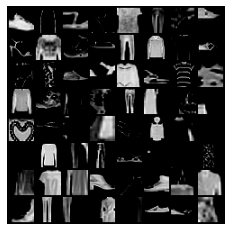

In [12]:
plt.imshow(train_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### Display a batch of validation data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


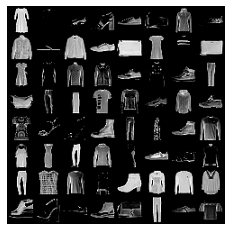

In [13]:
plt.imshow(val_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### Display a batch of test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


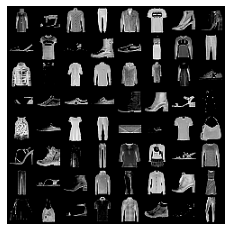

In [14]:
plt.imshow(test_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [15]:
!python --version

Python 3.7.7


## MLP training

In [16]:
import torch
import torch.nn as nn
from torch.nn import DataParallel
import time
import torch.optim as optim

from typing import Tuple, Any, List

def trainCls(model: nn.Module, train_loader: torch.utils.data.DataLoader, 
             val_loader: torch.utils.data.DataLoader, lr: float=0.1, epochs: int=100, 
             momentum: float=0.9, weight_decay: float=5e-4, 
             checkpoint: str='./checkpoint') -> Tuple[nn.Module, List, List, List, List]:
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device: {}'.format(device))
    
    model.to(device) # loading model to device

    if torch.cuda.device_count() > 1:
        if not isinstance(model, DataParallel):
            model = DataParallel(model) # if more that one gpu is available,
                                        # then wrap model with DataParallel,
                                        # so that it can be trained on multiple gpus
    
    model.to(device) # load model to device

    criterion = nn.CrossEntropyLoss() # loss-function for classification
    
    # optimizer is used to optime the model parameters while doing back-propagation
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    start = time.time()
    best_acc = 0.0
    
    trainLoss_, valLoss_ = list(), list()
    trainAcc_, valAcc_ = list(), list()
    
    start_epoch = 0

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            model.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            train_acc += predicted.eq(target).sum().item()
        
        train_loss, train_acc = train_loss/len(train_loader.sampler), train_acc/len(train_loader.sampler)
        trainLoss_.append(train_loss)
        trainAcc_.append(train_acc)

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        for _, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            val_acc += predicted.eq(target).sum().item()
        
        val_loss, val_acc = val_loss/len(val_loader.sampler), val_acc/len(val_loader.sampler)
        valLoss_.append(val_loss)
        valAcc_.append(val_acc)

        if val_acc > best_acc:
            print('Epoch: {} val accuracy improved: {:0.4f} ==> {:0.4f}'.format(epoch+1, best_acc, val_acc))
            best_acc = val_acc

            try:
                state_dict = model.state_dict()
            except:
                state_dict = model.module.state_dict()

            torch.save(state_dict, checkpoint)

        print('Epoch: [{}/{}] train_acc: {:0.4f} val_acc: {:0.4f} train_loss: {:0.4f} val_loss: {:0.4f}'.format(epoch+1, epochs, train_acc, val_acc, train_loss, val_loss))

    total_time = time.time() - start
    print('time: {:0.0f}m {:0.0f}s'.format((total_time//60), (total_time%60)))
    
    # loading model's best saved weight
    try:
        model.load_state_dict(torch.load(checkpoint, map_location=device))
    except:
        model.module.load_state_dict(torch.load(checkpoint, map_location=device))

    return model, trainLoss_, valLoss_, trainAcc_, valAcc_

## MLP evaluation

In [17]:
def testCls(model: nn.Module, test_loader: torch.utils.data.DataLoader, 
            checkpoint: str) -> Tuple[nn.Module, float, float]:
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device: {}'.format(device))
    
    model.to(device) # loading model to device

    if torch.cuda.device_count() > 1:
        if not isinstance(model, DataParallel):
            model = DataParallel(model) # if more that one gpu is available,
                                        # then wrap model with DataParallel,
                                        # so that it can be trained on multiple gpus
    
    model.to(device) # load model to device

    criterion = nn.CrossEntropyLoss() # loss-function for classification
    
    # loading model's saved weight
    try:
        model.load_state_dict(torch.load(checkpoint, map_location=device))
    except:
        model.module.load_state_dict(torch.load(checkpoint, map_location=device))

    model.eval()
    
    test_loss, test_acc = 0.0, 0.0
    for _, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        data = data.to(memory_format=torch.contiguous_format)

        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        test_acc += predicted.eq(target).sum().item()

    test_loss, test_acc = test_loss/len(test_loader.sampler), test_acc/len(test_loader.sampler)

    print('test_loss: {:0.4f} \t test_acc: {:0.4f}'.format(test_loss, test_acc))

    return model, test_loss, test_acc

## Defining MLP with PyTorch (Type - 1)

In [2]:
import torch.nn as nn

In [3]:
class MLP(nn.Module):
    
    def __init__(self, in_features: int=784, hidden_features: int=256, out_features: int=10) -> None:
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.fc3 = nn.Linear(in_features=hidden_features, out_features=out_features)
        
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        return self.fc3(out)

### Training MLP (Type - 1) with Pytorch

In [4]:
model = MLP()
print(model, '\n\n')

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
) 




In [21]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, checkpoint='mlp_type_1_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.6628
Epoch: [1/100] train_acc: 0.4195 val_acc: 0.6628 train_loss: 1.6451 val_loss: 0.9289
Epoch: 2 val accuracy improved: 0.6628 ==> 0.7059
Epoch: [2/100] train_acc: 0.5418 val_acc: 0.7059 train_loss: 1.2698 val_loss: 0.7977
Epoch: 3 val accuracy improved: 0.7059 ==> 0.7280
Epoch: [3/100] train_acc: 0.5682 val_acc: 0.7280 train_loss: 1.1870 val_loss: 0.7377
Epoch: 4 val accuracy improved: 0.7280 ==> 0.7546
Epoch: [4/100] train_acc: 0.5885 val_acc: 0.7546 train_loss: 1.1275 val_loss: 0.6727
Epoch: 5 val accuracy improved: 0.7546 ==> 0.7577
Epoch: [5/100] train_acc: 0.5990 val_acc: 0.7577 train_loss: 1.0944 val_loss: 0.6686
Epoch: 6 val accuracy improved: 0.7577 ==> 0.7664
Epoch: [6/100] train_acc: 0.6102 val_acc: 0.7664 train_loss: 1.0549 val_loss: 0.6392
Epoch: 7 val accuracy improved: 0.7664 ==> 0.7764
Epoch: [7/100] train_acc: 0.6172 val_acc: 0.7764 train_loss: 1.0426 val_loss: 0.6074
Epoch: 8 val accuracy improved: 0.7764 =

Epoch: [81/100] train_acc: 0.7134 val_acc: 0.8439 train_loss: 0.7723 val_loss: 0.4214
Epoch: [82/100] train_acc: 0.7133 val_acc: 0.8468 train_loss: 0.7752 val_loss: 0.4110
Epoch: [83/100] train_acc: 0.7136 val_acc: 0.8350 train_loss: 0.7749 val_loss: 0.4357
Epoch: [84/100] train_acc: 0.7165 val_acc: 0.8572 train_loss: 0.7665 val_loss: 0.3966
Epoch: [85/100] train_acc: 0.7156 val_acc: 0.8526 train_loss: 0.7677 val_loss: 0.3966
Epoch: [86/100] train_acc: 0.7126 val_acc: 0.8462 train_loss: 0.7719 val_loss: 0.4248
Epoch: [87/100] train_acc: 0.7188 val_acc: 0.8550 train_loss: 0.7633 val_loss: 0.4065
Epoch: [88/100] train_acc: 0.7133 val_acc: 0.8520 train_loss: 0.7677 val_loss: 0.3988
Epoch: [89/100] train_acc: 0.7193 val_acc: 0.8513 train_loss: 0.7667 val_loss: 0.4014
Epoch: 90 val accuracy improved: 0.8599 ==> 0.8617
Epoch: [90/100] train_acc: 0.7187 val_acc: 0.8617 train_loss: 0.7654 val_loss: 0.3905
Epoch: [91/100] train_acc: 0.7157 val_acc: 0.8578 train_loss: 0.7679 val_loss: 0.3859
Epo

In [22]:
model, test_loss, test_acc = testCls(model, test_loader, checkpoint='mlp_type_1_best_model.pth')

device: cuda:0
test_loss: 0.3982 	 test_acc: 0.8544


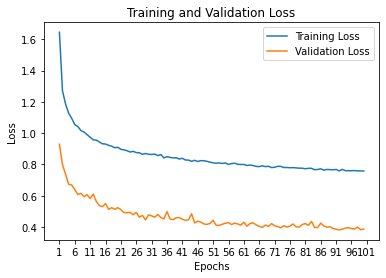

In [23]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

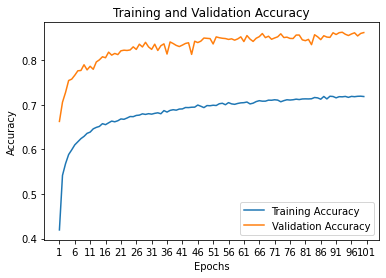

In [24]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

## Defining MLP with nn.Sequential() (Type - 2)

In [5]:
class MLP(nn.Module):
    
    def __init__(self, in_features: int=784, hidden_features: int=256, out_features: int=10) -> None:
        super(MLP, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=out_features)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.fc(x)

### Training MLP (Type - 2) with Pytorch

In [6]:
model = MLP()
print(model, '\n\n')

MLP(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) 




In [27]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, checkpoint='mlp_type_2_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.6579
Epoch: [1/100] train_acc: 0.4190 val_acc: 0.6579 train_loss: 1.6468 val_loss: 0.9572
Epoch: 2 val accuracy improved: 0.6579 ==> 0.7186
Epoch: [2/100] train_acc: 0.5420 val_acc: 0.7186 train_loss: 1.2778 val_loss: 0.7902
Epoch: 3 val accuracy improved: 0.7186 ==> 0.7442
Epoch: [3/100] train_acc: 0.5672 val_acc: 0.7442 train_loss: 1.1808 val_loss: 0.7306
Epoch: [4/100] train_acc: 0.5841 val_acc: 0.7179 train_loss: 1.1392 val_loss: 0.7576
Epoch: 5 val accuracy improved: 0.7442 ==> 0.7464
Epoch: [5/100] train_acc: 0.5973 val_acc: 0.7464 train_loss: 1.0996 val_loss: 0.6930
Epoch: 6 val accuracy improved: 0.7464 ==> 0.7575
Epoch: [6/100] train_acc: 0.6092 val_acc: 0.7575 train_loss: 1.0657 val_loss: 0.6592
Epoch: 7 val accuracy improved: 0.7575 ==> 0.7620
Epoch: [7/100] train_acc: 0.6183 val_acc: 0.7620 train_loss: 1.0395 val_loss: 0.6377
Epoch: [8/100] train_acc: 0.6253 val_acc: 0.7589 train_loss: 1.0188 val_loss: 0.6299
Epoch

Epoch: 78 val accuracy improved: 0.8560 ==> 0.8588
Epoch: [78/100] train_acc: 0.7110 val_acc: 0.8588 train_loss: 0.7795 val_loss: 0.4008
Epoch: [79/100] train_acc: 0.7096 val_acc: 0.8588 train_loss: 0.7839 val_loss: 0.3926
Epoch: [80/100] train_acc: 0.7128 val_acc: 0.8541 train_loss: 0.7724 val_loss: 0.4017
Epoch: [81/100] train_acc: 0.7123 val_acc: 0.8549 train_loss: 0.7769 val_loss: 0.3922
Epoch: [82/100] train_acc: 0.7104 val_acc: 0.8530 train_loss: 0.7795 val_loss: 0.4063
Epoch: [83/100] train_acc: 0.7109 val_acc: 0.8529 train_loss: 0.7776 val_loss: 0.4076
Epoch: [84/100] train_acc: 0.7098 val_acc: 0.8549 train_loss: 0.7721 val_loss: 0.4081
Epoch: [85/100] train_acc: 0.7107 val_acc: 0.8548 train_loss: 0.7767 val_loss: 0.4022
Epoch: [86/100] train_acc: 0.7142 val_acc: 0.8551 train_loss: 0.7730 val_loss: 0.4025
Epoch: [87/100] train_acc: 0.7127 val_acc: 0.8532 train_loss: 0.7744 val_loss: 0.4067
Epoch: 88 val accuracy improved: 0.8588 ==> 0.8627
Epoch: [88/100] train_acc: 0.7130 val_

In [28]:
model, test_loss, test_acc = testCls(model, test_loader, checkpoint='mlp_type_2_best_model.pth')

device: cuda:0
test_loss: 0.3977 	 test_acc: 0.8592


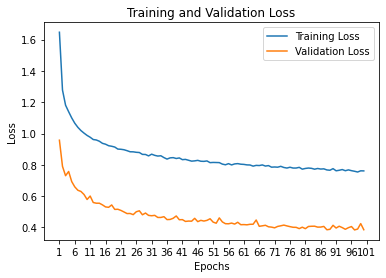

In [29]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

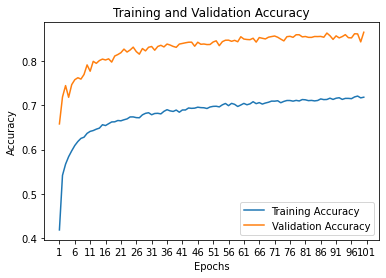

In [30]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

## Defining MLP with Dropout (Type - 3)

In [7]:
class MLP(nn.Module):
    
    def __init__(self, in_features: int=784, hidden_features: int=256, out_features: int=10, 
                 rate: float=0.4) -> None:
        super(MLP, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Dropout(p=rate),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Dropout(p=rate),
            nn.Linear(in_features=hidden_features, out_features=out_features)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.fc(x)

### Training MLP (Type - 3) with Pytorch

In [8]:
model = MLP()
print(model, '\n\n')

MLP(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
) 




In [33]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, checkpoint='mlp_type_3_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.6364
Epoch: [1/100] train_acc: 0.3578 val_acc: 0.6364 train_loss: 1.7683 val_loss: 1.0373
Epoch: 2 val accuracy improved: 0.6364 ==> 0.6978
Epoch: [2/100] train_acc: 0.4830 val_acc: 0.6978 train_loss: 1.4325 val_loss: 0.8554
Epoch: 3 val accuracy improved: 0.6978 ==> 0.7121
Epoch: [3/100] train_acc: 0.5136 val_acc: 0.7121 train_loss: 1.3402 val_loss: 0.8035
Epoch: 4 val accuracy improved: 0.7121 ==> 0.7222
Epoch: [4/100] train_acc: 0.5367 val_acc: 0.7222 train_loss: 1.2784 val_loss: 0.7683
Epoch: 5 val accuracy improved: 0.7222 ==> 0.7354
Epoch: [5/100] train_acc: 0.5465 val_acc: 0.7354 train_loss: 1.2441 val_loss: 0.7281
Epoch: 6 val accuracy improved: 0.7354 ==> 0.7407
Epoch: [6/100] train_acc: 0.5540 val_acc: 0.7407 train_loss: 1.2210 val_loss: 0.7141
Epoch: 7 val accuracy improved: 0.7407 ==> 0.7441
Epoch: [7/100] train_acc: 0.5617 val_acc: 0.7441 train_loss: 1.2016 val_loss: 0.6893
Epoch: 8 val accuracy improved: 0.7441 =

Epoch: 80 val accuracy improved: 0.8324 ==> 0.8334
Epoch: [80/100] train_acc: 0.6503 val_acc: 0.8334 train_loss: 0.9494 val_loss: 0.4616
Epoch: [81/100] train_acc: 0.6510 val_acc: 0.8277 train_loss: 0.9494 val_loss: 0.4658
Epoch: [82/100] train_acc: 0.6485 val_acc: 0.8306 train_loss: 0.9515 val_loss: 0.4620
Epoch: [83/100] train_acc: 0.6530 val_acc: 0.8322 train_loss: 0.9518 val_loss: 0.4636
Epoch: [84/100] train_acc: 0.6519 val_acc: 0.8261 train_loss: 0.9507 val_loss: 0.4701
Epoch: [85/100] train_acc: 0.6534 val_acc: 0.8266 train_loss: 0.9445 val_loss: 0.4717
Epoch: [86/100] train_acc: 0.6529 val_acc: 0.8317 train_loss: 0.9457 val_loss: 0.4607
Epoch: [87/100] train_acc: 0.6524 val_acc: 0.8329 train_loss: 0.9495 val_loss: 0.4691
Epoch: 88 val accuracy improved: 0.8334 ==> 0.8337
Epoch: [88/100] train_acc: 0.6549 val_acc: 0.8337 train_loss: 0.9443 val_loss: 0.4625
Epoch: [89/100] train_acc: 0.6515 val_acc: 0.8333 train_loss: 0.9506 val_loss: 0.4634
Epoch: [90/100] train_acc: 0.6506 val_

In [34]:
model, test_loss, test_acc = testCls(model, test_loader, checkpoint='mlp_type_3_best_model.pth')

device: cuda:0
test_loss: 0.4525 	 test_acc: 0.8364


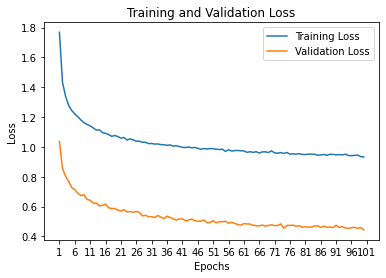

In [35]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

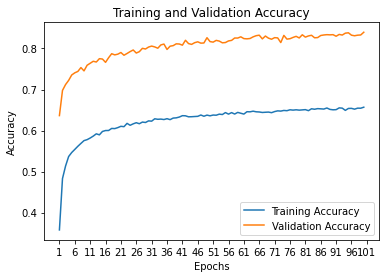

In [36]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()